# Setup

In [72]:
import getpass
import numpy as np
import matplotlib.pyplot as plt

import axs
import pyspark.sql.functions as sparkfunc
import pyspark.sql.types as sparktypes

import pandas as pd

import dipper

In [2]:
%matplotlib notebook

# Load Steven's data

In [3]:
from pyspark.sql import SparkSession
spark = ( 
    SparkSession
    .builder
    .config("spark.master", "local[*]")
    .config("spark.driver.memory", "120g")
    .config("spark.driver.maxResultSize", "0")
    .enableHiveSupport()
    .getOrCreate()
)
import axs
catalog = axs.AxsCatalog(spark)
joined_df = catalog.load("6_4_20_stevengs_top_hat_and_skew_normal_fits_r_band")

In [34]:
base_df = catalog.load("stevengs_cut_wtf").toPandas()

In [13]:
df_dict = {
    'skew_r': '8_5_20_stevengs_skew_normal_fits_r_band',
    'skew_g': '8_5_20_stevengs_skew_normal_fits_g_band',
    'skew_i': '8_5_20_stevengs_skew_normal_fits_i_band',
    'tophat_r': '8_5_20_stevengs_top_hat_fits_r_band',
    'tophat_g': '8_5_20_stevengs_top_hat_fits_g_band',
    'tophat_i': '8_5_20_stevengs_top_hat_fits_i_band',
}

In [14]:
pandas_dfs = {}
for label, name in df_dict.items():
    pandas_dfs[label] = catalog.load(name).toPandas()

In [109]:
merged_df = base_df[base_df['dup'] == 0]
for channel in ['r', 'g', 'i']:
    
    df_1 = pandas_dfs[f'skew_{channel}']
    df_2 = pandas_dfs[f'tophat_{channel}']
    
    df_1 = df_1[df_1['dup'] == 0]
    df_2 = df_2[df_2['dup'] == 0]
    
    channel_df = pd.merge(
        df_1,
        df_2,
        how='inner',
        on='ps1_objid',
        suffixes=[f'_skew_{channel}', f'_tophat_{channel}']
    )
    merged_df = pd.merge(merged_df, channel_df, on='ps1_objid', how='left')

In [128]:
def extract_key(key, subkey):
    return np.array([i[subkey] if isinstance(i, sparktypes.Row) else i for i in merged_df[key]])

def extract_key_item(key, subkey, item):
    return np.array([i[subkey][item] if isinstance(i, sparktypes.Row) else i for i in merged_df[key]])

In [133]:
chisq_skew_g = extract_key('model_error_around_dip_g_skew_g', 'reduced_sum_square_error')
chisq_skew_r = extract_key('model_error_around_dip_r_skew_r', 'reduced_sum_square_error')
chisq_skew_i = extract_key('model_error_around_dip_i_skew_i', 'reduced_sum_square_error')
chisq_tophat_g = extract_key('model_error_around_dip_g_tophat_g', 'reduced_sum_square_error')
chisq_tophat_r = extract_key('model_error_around_dip_r_tophat_r', 'reduced_sum_square_error')
chisq_tophat_i = extract_key('model_error_around_dip_i_tophat_i', 'reduced_sum_square_error')

skew_g = extract_key_item('fit_g_skew_g', 'popt', 0)
xscale_g = extract_key_item('fit_g_skew_g', 'popt', 2)
yscale_g = extract_key_item('fit_g_skew_g', 'popt', 3)
skew_r = extract_key_item('fit_r_skew_r', 'popt', 0)
xscale_r = extract_key_item('fit_r_skew_r', 'popt', 2)
yscale_r = extract_key_item('fit_r_skew_r', 'popt', 3)
skew_i = extract_key_item('fit_i_skew_i', 'popt', 0)
xscale_i = extract_key_item('fit_i_skew_i', 'popt', 2)
yscale_i = extract_key_item('fit_i_skew_i', 'popt', 3)

In [160]:
def skew_normal(x, skew, loc, xscale, yscale, offset):
    from scipy.stats import skewnorm
    _dist = skewnorm(skew, loc=loc, scale=xscale)
    return yscale * _dist.pdf(x) + offset

def top_hat(x, loc, width, depth, offset):
    import numpy as np
    x = np.array(x)
    left = loc - width / 2
    right = loc + width / 2
    outside = (x < left) | (x > right)
    inside = np.logical_not(outside)
    
    y = np.zeros(x.shape)
    y[outside] = offset
    y[inside] = offset + depth
    
    return y

In [298]:
colormap = {
    'g': 'tab:green',
    'r': 'tab:red',
    'i': 'tab:purple',
}

def plot_row(row):
    dip = row['dip']

    fig, subplots = plt.subplots(3, 1, figsize=(8, 9), sharex=True, gridspec_kw={'hspace': 0.05})
    
    start_mjd = dip['window_start_mjd']
    end_mjd = dip['window_end_mjd']
    pad = end_mjd - start_mjd

    x = np.linspace(start_mjd - pad, end_mjd + pad, 1000)

    for subplot, channel in zip(subplots, ['r', 'g', 'i']):
        c = colormap[channel]
        
        mjd = np.array(row[f'mjd_{channel}'])
        mag = np.array(row[f'mag_{channel}'])
        magerr = np.array(row[f'magerr_{channel}'])
        
        mask = (mjd > start_mjd - pad) & (mjd < end_mjd + pad)

        subplot.errorbar(mjd[mask], mag[mask], magerr[mask], fmt='o', c=c, label=f'{channel} observations')

        fit = row[f'fit_{channel}_skew_{channel}']
        if fit is not np.nan:
            model = skew_normal(x, *fit['popt'])
            chisq = row[f"model_error_around_dip_{channel}_skew_{channel}"][1]
            subplot.plot(x, model, label=f'Skew normal fit {channel} - {chisq:.2f}', c='C0')

        fit = row[f'fit_{channel}_tophat_{channel}']
        if fit is not np.nan:
            model = top_hat(x, *fit['popt'])
            chisq = row[f"model_error_around_dip_{channel}_tophat_{channel}"][1]
            subplot.plot(x, model, label=f'Top hat fit {channel} - {chisq:.2f}', c='C1')        

        subplot.invert_yaxis()
        subplot.legend()
        subplot.set_xlim(start_mjd - pad, end_mjd + pad)

        subplot.axvline(start_mjd, c='k', ls='--')
        subplot.axvline(end_mjd, c='k', ls='--')

        subplot.set_ylabel('Magnitude')
        
    subplots[2].set_xlabel('MJD')
    subplots[0].set_title(row['ps1_objid'])

In [299]:
sig = extract_key('dip', 'significance')

In [305]:
cut = (
    # g
    (
        (chisq_skew_g < 5)
        & (np.abs(skew_g) > 2)
        & (np.abs(yscale_g) < 4)
        & (np.abs(xscale_g) < 50)
        & (chisq_tophat_g - chisq_skew_g > 2)
    )
    # r
    | (
        (chisq_skew_r < 5)
        & (np.abs(skew_r) > 2)
        & (np.abs(yscale_r) < 4)
        & (np.abs(xscale_r) < 50)
        & (chisq_tophat_r - chisq_skew_r > 2)
    )
    # i
    | (
        (chisq_skew_i < 5)
        & (np.abs(skew_i) > 2)
        & (np.abs(yscale_i) < 4)
        & (np.abs(xscale_i) < 50)
        & (chisq_tophat_i - chisq_skew_i > 2)
    )
)

cut_df = merged_df.iloc[cut]

/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less
/epyc/opt/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater


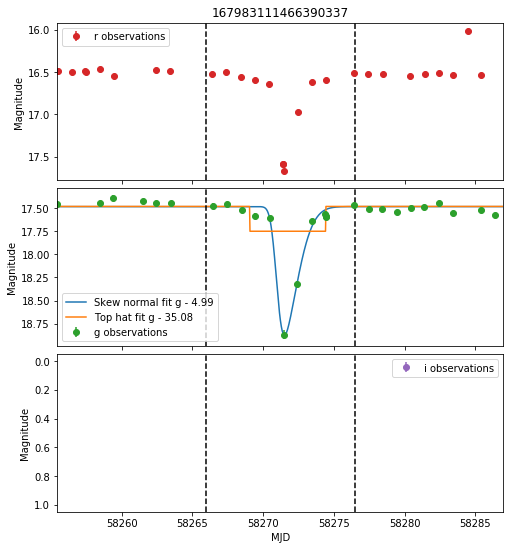

In [313]:
sig = extract_key('dip', 'significance')
sig_df = cut_df.iloc[np.argsort(sig[cut])[::-1]]
plot_row(sig_df.iloc[0])

In [314]:
%matplotlib inline

In [319]:
from tqdm.notebook import tqdm

In [ ]:
tqdm()

In [ ]:
for row_id, row in tqdm(cut_df.iterrows(), total=len(cut_df)):
    plot_row(row)
    plt.savefig(f'./zooniverse/{row["ps1_objid"]}.png')
    plt.close()